<a href="https://colab.research.google.com/github/kutay-oksuzz/-Deeplearning_FashionMNIST_compare_CNN_and_non-linear_models/blob/main/Deeplearning_FashionMNIST_compare_CNN_and_non_linear_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib
import matplotlib.pyplot as plt

In [102]:
# Setup agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [103]:
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # do we want the training dataset?
    transform=ToTensor(), # how do we want to transform the data?
    download=True,
    target_transform=None # how do we want to transfrom the labels/data?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True,
    target_transform=None
)

In [104]:
len(train_data), len(test_data)

(60000, 10000)

In [105]:
# See the first training example
image, label = train_data[911]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.1529, 0.5882, 0.2980, 0.0000, 0.0000, 0.0000, 0.0000,
           0.1608, 0.6078, 0.2353, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.9216, 0.8353, 0.7529, 0.8980, 1.0000, 0.9059, 0.8627, 1.0000,
           0.8824, 0.8392, 0.8431, 0.7294, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4588,
           0.8431, 0.7373, 0.7569, 0.7961, 0.8706, 0.9647, 0.9922, 0.8824,
           0.7333, 0.8196, 0.5961, 0.7490, 0.3451, 0.0000, 0.0078, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5137,
           0.8431, 0.7882, 0.7373, 0.4980, 0.8118, 0.7098, 0.6471, 0.7333,
           0.6510, 0.9059, 0.7333, 0.5725, 

In [106]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [107]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Dress


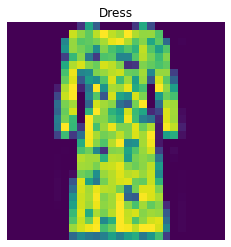

In [108]:
# Visualize the our image
plt.imshow(image.squeeze()) # image shape is [1, 28, 28]
plt.title(class_names[label])
plt.axis(False);

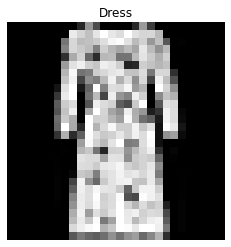

In [109]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False);

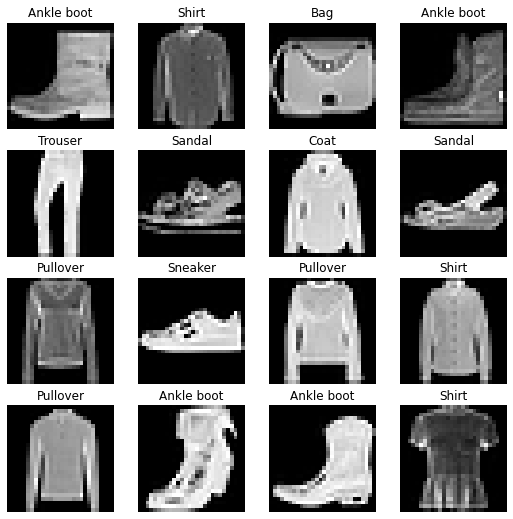

In [110]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [111]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True,  # shuffle data every epoch?
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

print(f"Dataloader: {train_dataloader, test_dataloader}")
print(f"Lenght of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloader: (<torch.utils.data.dataloader.DataLoader object at 0x7fa310de9400>, <torch.utils.data.dataloader.DataLoader object at 0x7fa310de9070>)
Lenght of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [112]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [113]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # flatten inputs into single vector [1, 28, 28] -> [1, 28*28]
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU(),
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [114]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape=28*28, # number of input features
                              hidden_units=10,
                              output_shape=len(class_names) # number of output classes desired
                              ).to(device) # check model device

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [115]:
# Create a convolutional neural network 
class FashionMNISTModelV1(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [116]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)
                              ).to(device)

model_1

FashionMNISTModelV1(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [117]:
# Setup accuracy metric
def accuracy_fn(y_true, y_pred):
  """Calculates accuracy between truth labels and predictions.

  Args:
      y_true (torch.Tensor): Truth labels for predictions.
      y_pred (torch.Tensor): Predictions to be compared to predictions.

  Returns:
      [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
  """
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [118]:
# Setup loss function and optimizer (We will use the same loss and optimizer functions for both models)
loss_fn = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)
optimizer_2 = torch.optim.SGD(params=model_1.parameters(),
                              lr=0.1)

In [119]:
# Create train functions
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn: accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(data_loader):
    # Send data to GPU
    X, y = X.to(device), y.to(device)
    
    # 1. Forward the pass
    y_pred = model(X)

    # 2. Calculate the loss and accuracy
    loss = loss_fn(y_pred,
                   y)
    train_loss += loss

    train_acc += accuracy_fn(y_true=y,
                            y_pred=y_pred.argmax(dim=1)) # logits -> pred labels

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")    

In [120]:
# Create test function
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn: accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      # Send data to GPU
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss and accuracy
      test_loss += loss_fn(test_pred,
                          y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # logits -> pred labels
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")  


    


In [128]:
# Create predictions function
from tqdm.auto import tqdm
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn: accuracy_fn,
               device: torch.device = device):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate loss and accuracy
      loss += loss_fn(y_pred,
                      y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"mode_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}   

In [122]:
# Training and testing a model_0 (non-linear) on batches of data
from tqdm.auto import tqdm

# Set the seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")

  # Training
  train_step(model=model_0,
             data_loader=train_dataloader,
             loss=loss_fn,
             optimizer=optimizer_1,
             accuracy_fn=accuracy_fn,
             device=device)
  
  # Testing
  test_step(model=model_0,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95636 | Test accuracy: 65.00%

Epoch: 1
--------
Train loss: 0.78101 | Train accuracy: 71.93%
Test loss: 0.72227 | Test accuracy: 73.91%

Epoch: 2
--------
Train loss: 0.67027 | Train accuracy: 75.94%
Test loss: 0.68500 | Test accuracy: 75.02%



In [123]:
torch.manual_seed(42)



# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss=loss_fn,
        optimizer=optimizer_2,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59400 | Train accuracy: 78.56%
Test loss: 0.39420 | Test accuracy: 85.70%

Epoch: 1
---------
Train loss: 0.36112 | Train accuracy: 87.01%
Test loss: 0.35276 | Test accuracy: 86.81%

Epoch: 2
---------
Train loss: 0.32461 | Train accuracy: 88.28%
Test loss: 0.31903 | Test accuracy: 88.65%



In [129]:
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'mode_name': 'FashionMNISTModelV0',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [130]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'mode_name': 'FashionMNISTModelV1',
 'model_loss': 0.3190315067768097,
 'model_acc': 88.64816293929712}